# Conv4 3D Residual v3

### Here we compare different approaches to training the network
### and visualize performance of the network on validation set for different signal classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

#os.environ["CUDA_VISIBLE_DEVICES"] = '0'
#from cnn_utils import *

In [2]:
def bckg_rej(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    #if tpfp<1: print('nothing positive, thresh:',thresh)
    return np.invert(a_true).sum()/((a_pred>thresh)[np.invert(a_true)]).sum()

def precise(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    #if tpfp<1: print('nothing positive, thresh:',thresh)
    return ((a_pred>thresh)[a_true]).sum()/(a_pred>thresh).sum()

def accurate(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    tp = ((a_pred>thresh)[a_true]).sum()
    tn = ((a_pred<thresh)[np.invert(a_true)]).sum()
    return (tp+tn)/len(a_true)

def efficiate(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    return ((a_pred>thresh)[a_true]).sum()/np.sum(a_true)

def rej_eff_curve(y_true, y_pred, thresh_curve):
    return [bckg_rej(y_true, y_pred, th) for th in thresh_curve], [efficiate(y_true, y_pred, th) for th in thresh_curve]

def pos_neg(y, preds):
    pos = np.array([[],[]]).T
    neg = np.array([[],[]]).T
    preds = np.ravel(preds)
    for i,grek in enumerate(y):
        if grek:
            pos = np.vstack((pos, np.array([preds[i],i])))
        else:
            neg = np.vstack((neg, [preds[i],i]))
    gc.collect()
    return pos, neg

In [3]:
N_ep = 50; batch = 256; i=0; n_fold = 4
sig_names = ['Carbon/100keV','Carbon/60keV','Carbon/30keV']
bckg_names = ['fog','gamma/Cs137','gamma/Co60']
train_types = ['no_rot','rot']
#load_s = []
#for n in class_names:
#    load_s += [(n+'-'+str(i)) for i in range(1,n_fold+1)]
#dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_phys_clean.h5'

In [4]:
def pred_name(sig,bckg,i=None):
    return '-'.join(sig.split('/'))+'_'+'-'.join(bckg.split('/'))+'__'+str(i) if i else '-'.join(sig.split('/'))+'_'+'-'.join(bckg.split('/'))

In [5]:
pred_dir = 'outputs/conv4_3d_res/v3/preds'
preds = {}
for tr in train_types:
    for s in sig_names:
        for b in bckg_names:
            preds[s+'_'+b+'_'+tr] = np.loadtxt(pred_dir+'/'+tr+'/'+'e'+str(N_ep)+'_'+pred_name(s,b)+'.txt')
            #print('')

In [6]:
preds['Carbon/100keV_gamma/Co60_no_rot'].shape

(118984, 2)

In [7]:
preds['Carbon/100keV_gamma/Co60_rot'].shape

(118984, 2)

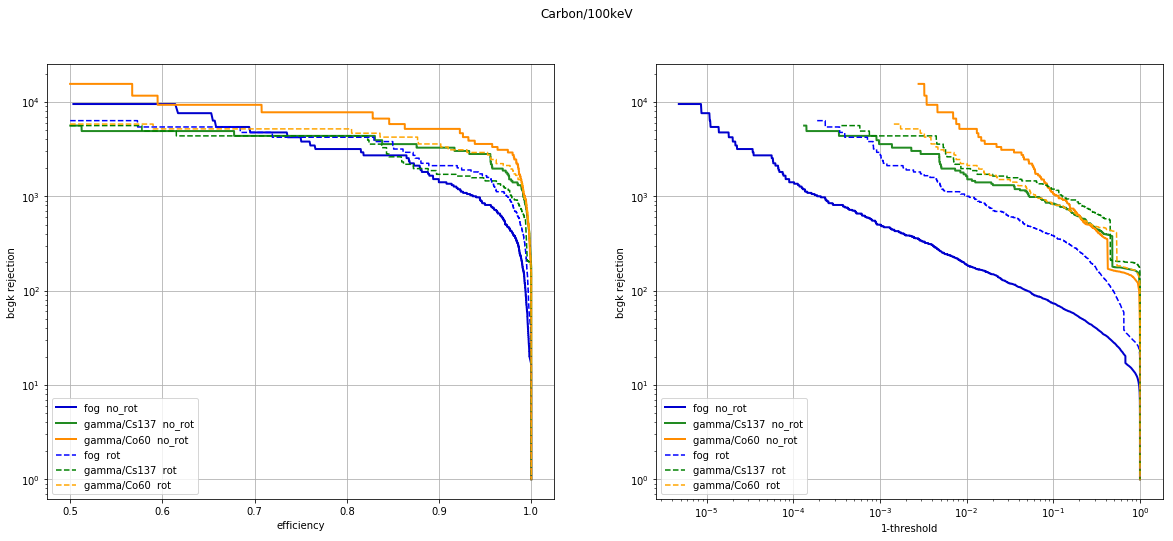

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in reciprocal
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in reciprocal


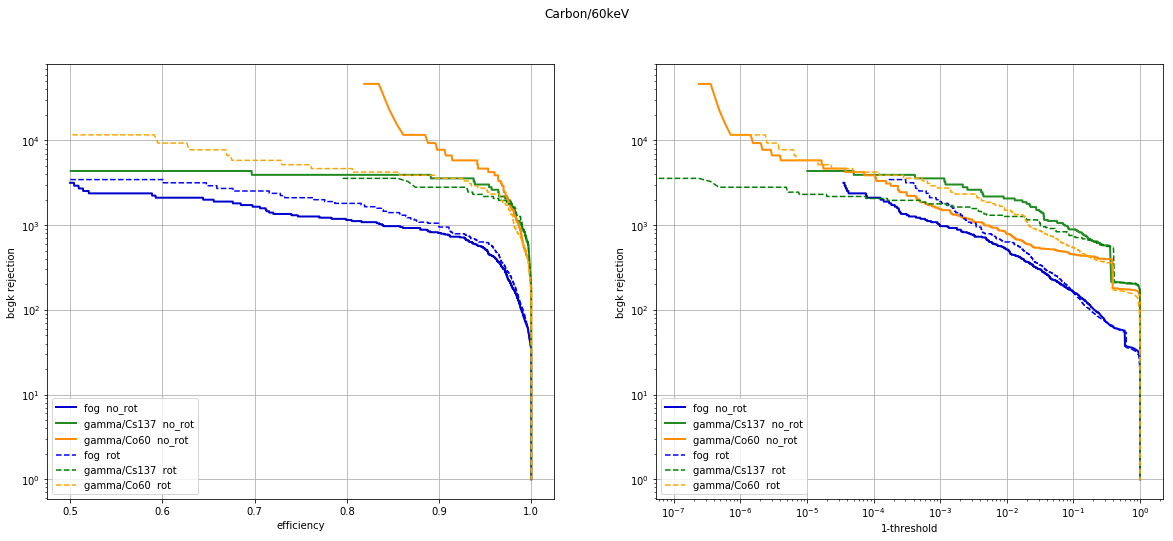

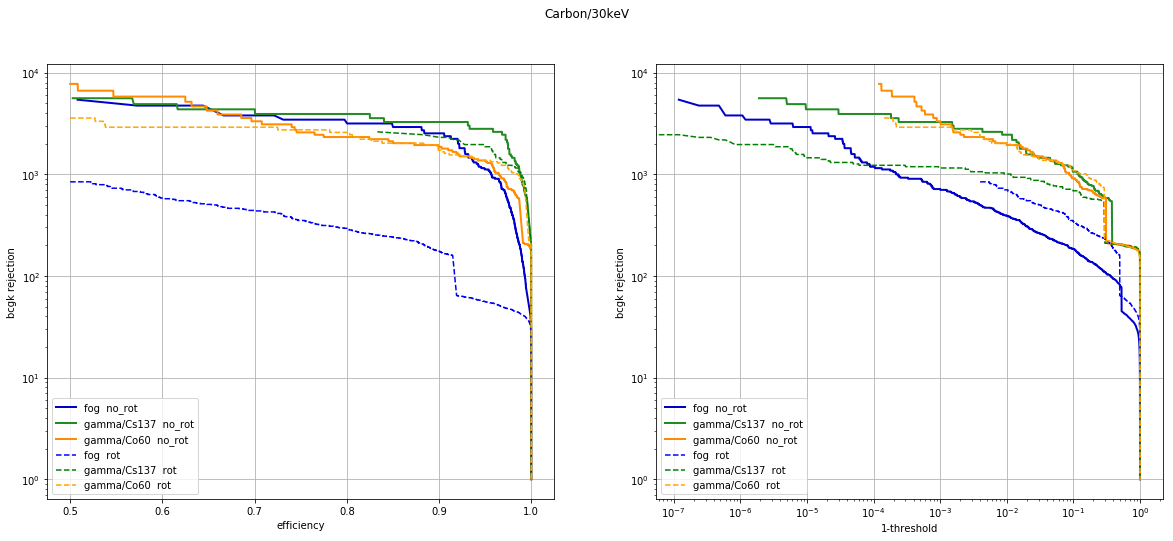

In [12]:
col = {'fog':'mediumblue','gamma/Co60':'darkorange','gamma/Cs137':'forestgreen'}
col_rot = {'fog':'blue','gamma/Co60':'orange','gamma/Cs137':'green'}
for s in sig_names:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    #plt.figure(figsize=(12,8))
    fig.suptitle(s)
    for i in range(2):
        axes[i].grid()
        axes[i].set_yscale('log')
        axes[i].set_ylabel('bcgk rejection')
        #plt.savefig('outputs/conv4_3d_res/v3/'+'_'.join(s.split('/'))+'.pdf')
    axes[0].set_xlabel('efficiency')
    axes[1].set_xlabel('1-threshold')
    axes[1].set_xscale('log')
    for tr in train_types:
        for b in bckg_names:

            #for i in range(1,n_fold+1):
            #    fpr, tpr, _ = roc_curve(preds[s+'_'+b+'-'+str(i)+'_'+tr][:,1],preds[s+'_'+b+'-'+str(i)+'_'+tr][:,0])
            #    plt.plot(tpr,fpr**-1)
            fpr, tpr, thr = roc_curve(preds[s+'_'+b+'_'+tr][:,1],preds[s+'_'+b+'_'+tr][:,0])
            mask = tpr>0.5
            if tr=='no_rot': axes[0].plot(tpr[mask],(fpr[mask])**-1,color=col[b],linewidth=2,label=b+'  '+tr)
            else: axes[0].plot(tpr[mask],(fpr[mask])**-1,color=col_rot[b], linestyle='--',linewidth=1.5,label=b+'  '+tr)
            if tr=='no_rot': axes[1].plot((1-thr)[mask],(fpr[mask])**-1,color=col[b],linewidth=2,label=b+'  '+tr)
            else: axes[1].plot((1-thr)[mask],(fpr[mask])**-1,color=col_rot[b], linestyle='--',linewidth=1.5,label=b+'  '+tr)
            
    for i in range(2):
        axes[i].legend(loc=3)
    plt.show()


/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  from ipykernel import kernelapp as app


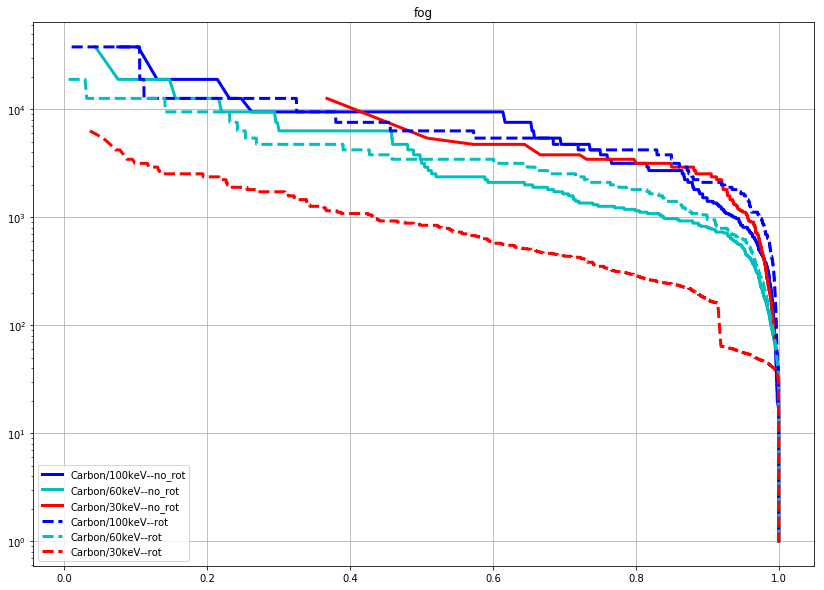

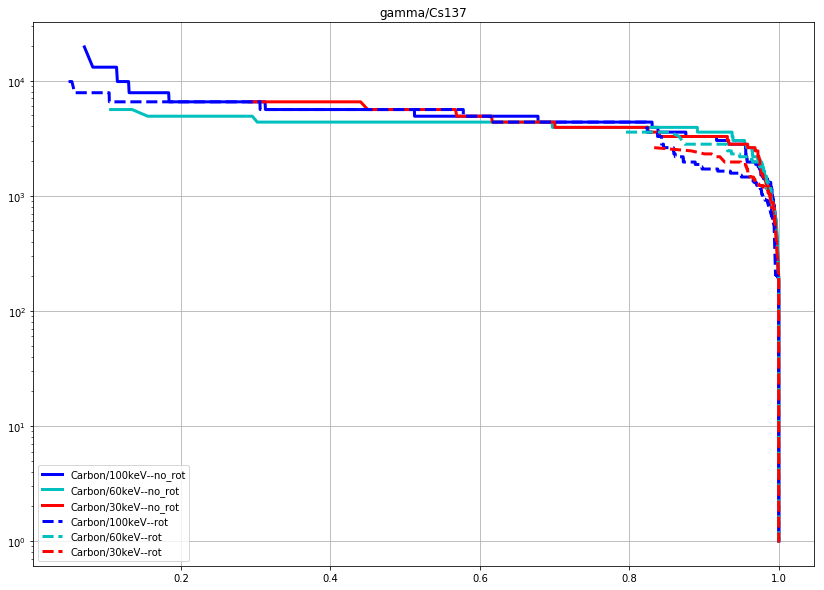

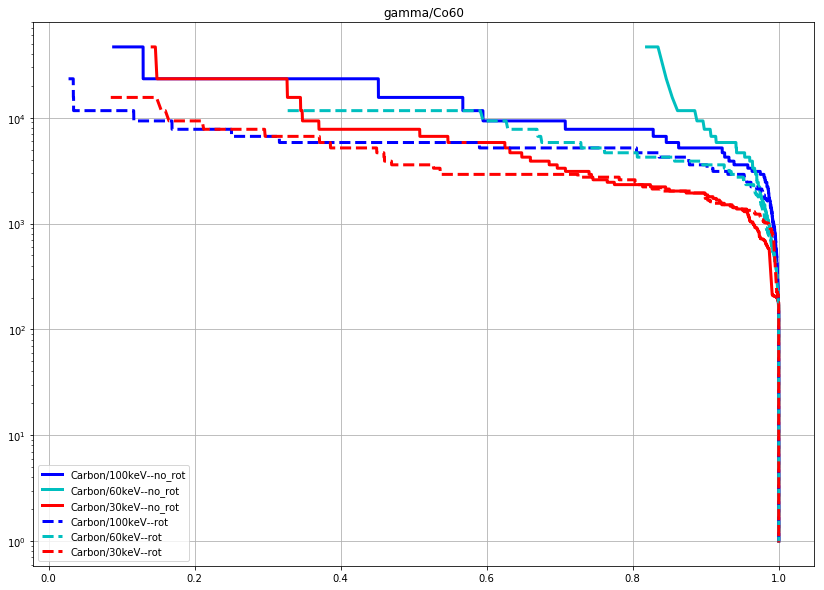

In [11]:
col = {'Carbon/100keV':'b','Carbon/60keV':'c','Carbon/30keV':'r'}
for b in bckg_names:
    plt.figure(figsize=(14,10))
    plt.title(b)
    plt.grid()
    plt.yscale('log')
    for tr in train_types:
        for s in sig_names:

            #for i in range(1,n_fold+1):
            #    fpr, tpr, _ = roc_curve(preds[s+'_'+b+'-'+str(i)+'_'+tr][:,1],preds[s+'_'+b+'-'+str(i)+'_'+tr][:,0])
            #    plt.plot(tpr,fpr**-1)
            fpr, tpr, _ = roc_curve(preds[s+'_'+b+'_'+tr][:,1],preds[s+'_'+b+'_'+tr][:,0])
            if tr=='no_rot': plt.plot(tpr,fpr**-1,col[s],linewidth=3,label=s+'--'+tr)
            else: plt.plot(tpr,fpr**-1,col[s]+'--',linewidth=3,label=s+'--'+tr)
    plt.legend(loc=3)
    plt.show()


In [7]:
'''threshs = {}
for n in class_names:
    for s in preds.keys():
        if not s.startswith(n) or n in threshs.keys(): continue
        threshs[n] = precision_recall_curve(preds[s][:,1], preds[s][:,0])[2][:-1]'''
pr_curves, min_eff, interp = {},{},{}
#thr_curves, min_thr, inter_thr = {},{},{}
#for n in class_names: min_eff[n] = 0.6
thresh = 1-np.logspace(1,8,num=40,base=5)**-1
for tr in train_types:
    for s in sig_names:
        for b in bckg_names:
            for i in range(1,n_fold+1):
                #if not s.startswith(n): continue
                rej, eff, th = roc_curve(preds[s+'_'+b+'-'+str(i)+'_'+tr][:,1],preds[s+'_'+b+'-'+str(i)+'_'+tr][:,0])
                rej = rej**-1
                sort_ind = np.argsort(eff)
                interp[s+'_'+b+'-'+str(i)+'_'+tr] = sp.interpolate.interp1d(eff, rej, fill_value='extrapolate')
                #if eff[sort_ind[0]]>min_eff[n]: min_eff[n] = eff[sort_ind[0]]

pr_curves['bckg_rejection'], pr_curves['efficiency'], pr_curves['type'], pr_curves['model'],pr_curves['bckg'],pr_curves['signal'] = [],[],[],[],[],[]
#thr_curves['class'], thr_curves['bckg_rejection'], thr_curves['inv_threshold'], thr_curves['type'], thr_curves['model'] = [],[],[],[],[]
for tr in train_types:
    for s in sig_names:
        for b in bckg_names:
            for i in range(1,n_fold+1):
            #if not s.startswith(n): continue
            #eff = min_eff[n] + (np.sort(np.logspace(1,8,num=100,base=2)**-1)*2*(1-min_eff[n]))[:-1]
                eff = np.linspace(0.3,1,1000)
                #pr_curves['class'] += [n]*len(eff)
                pr_curves['efficiency'] += list(eff)
                pr_curves['bckg_rejection'] += list(interp[s+'_'+b+'-'+str(i)+'_'+tr](eff))
                pr_curves['model'] += [s+'_'+b]*len(eff)
                pr_curves['type'] += [tr]*len(eff)
                pr_curves['signal'] += [s]*len(eff)
                pr_curves['bckg'] += [b]*len(eff)
                #rej, eff = rej_eff_curve(preds[n+'_'+s+'_'+tr][:,1],preds[n+'_'+s+'_'+tr][:,0],thresh)
                #thr_curves['class'] += [n]*len(eff)
                #thr_curves['inv_threshold'] += list((1-thresh))
                #thr_curves['bckg_rejection'] += rej
                #thr_curves['model'] += [s[:-2]]*len(eff)
                #thr_curves['type'] += [tr]*len(eff)
pr_curves = pd.DataFrame(data=pr_curves)
#thr_curves = pd.DataFrame(data=thr_curves)
_ = gc.collect()

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  app.launch_new_instance()
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [13]:
gc.collect()

0

In [14]:
class_names = []
for s in sig_names:
    for b in bckg_names:
        class_names.append(s+'_'+b)

In [15]:
class_names

['Carbon/100keV_fog',
 'Carbon/100keV_gamma/Cs137',
 'Carbon/100keV_gamma/Co60',
 'Carbon/60keV_fog',
 'Carbon/60keV_gamma/Cs137',
 'Carbon/60keV_gamma/Co60',
 'Carbon/30keV_fog',
 'Carbon/30keV_gamma/Cs137',
 'Carbon/30keV_gamma/Co60']

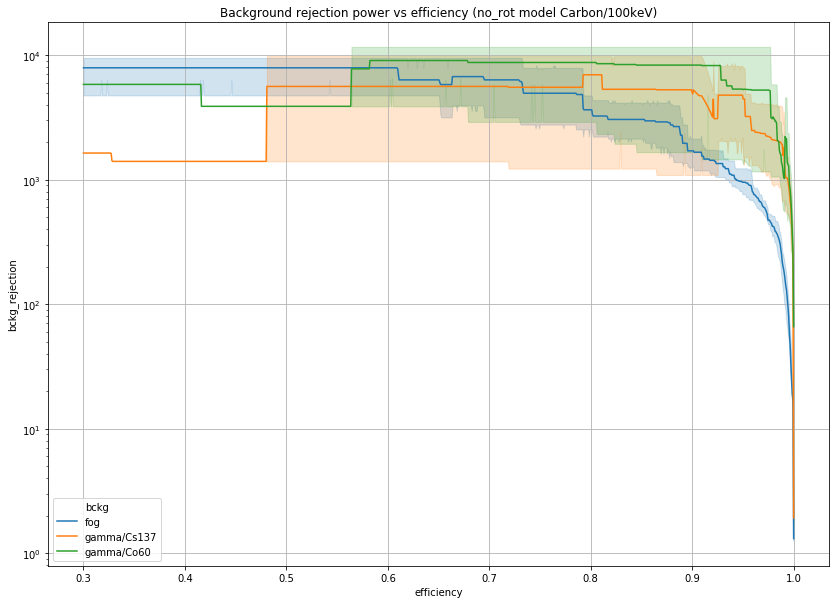

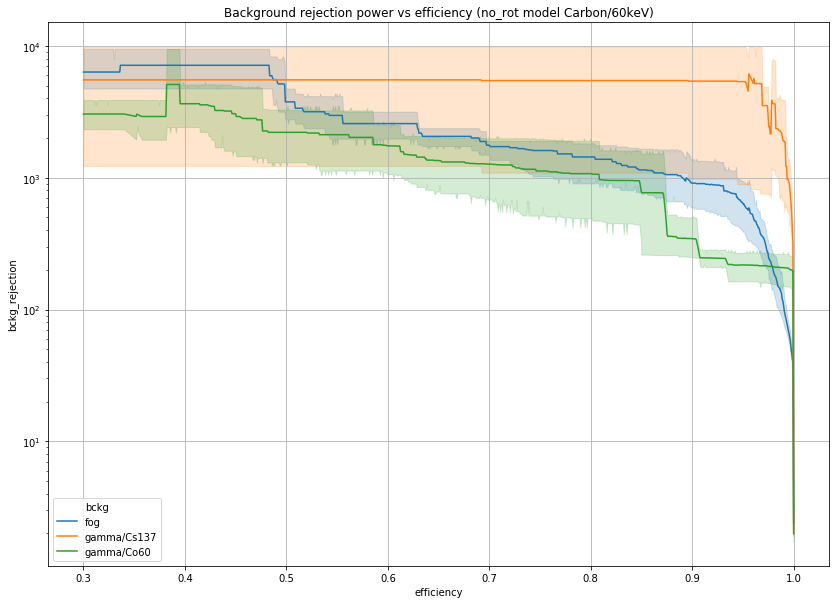

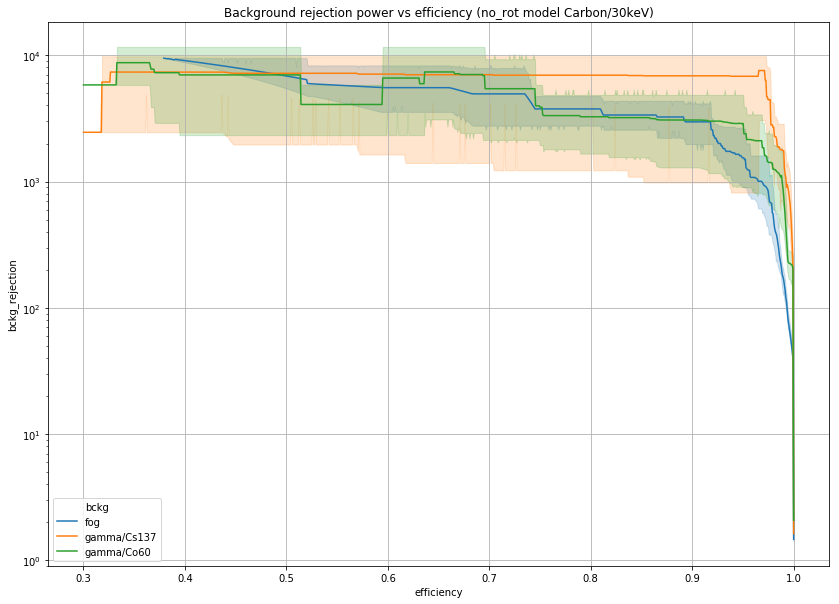

In [16]:
for s in sig_names:
    # n is a class (==model)
    #if not any([n in s for s in load_s]): continue
    
    plt.figure(figsize=(14,10))
    sns.lineplot(x='efficiency',y='bckg_rejection',hue='bckg', data=pr_curves[pr_curves['signal']==s])
    plt.grid()
    plt.yscale('log')
    #plt.xscale('logit')
    plt.title('Background rejection power vs efficiency (no_rot model '+s+')')
    plt.show()   
    '''
    print('\n\n\nIf we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1\n\n')
    
    plt.figure(figsize=(14,10))
    sns.lineplot(x='inv_threshold',y='bckg_rejection',hue='type', data=thr_curves[thr_curves['class']==n])
    plt.grid()
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Background rejection power from probability thresholds ('+n+' vs fog)')
    plt.show()'''
    
    print('\n\n')

# REPAIR BELOW

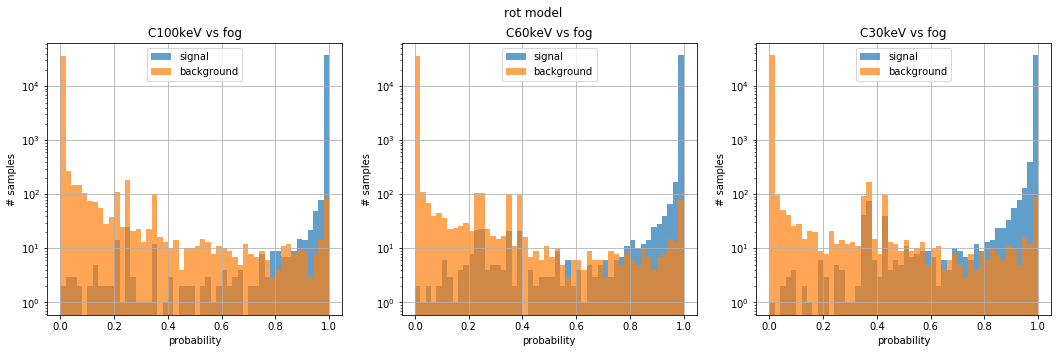

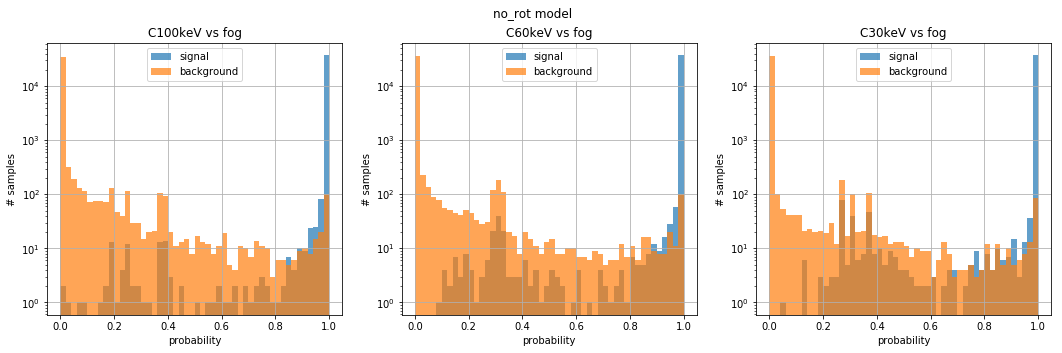

In [105]:
for tr in train_types:
    pred_mean, pos, neg = {},{},{}
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, k in enumerate(class_names):
        n=k
        #if k!='C100keV': continue
        pos[k+'_'+n+'_'+tr], neg[k+'_'+n+'_'+tr] = np.zeros((0,2)), np.zeros((0,2))
        for s in [m for m in load_s if n in m]:
            pos[k+'_'+s+'_'+tr], neg[k+'_'+s+'_'+tr] = pos_neg(preds[k+'_'+s+'_'+tr][:,1], preds[k+'_'+s+'_'+tr][:,0])
            pos[k+'_'+n+'_'+tr] = np.vstack((pos[k+'_'+n+'_'+tr],pos[k+'_'+s+'_'+tr]))
            neg[k+'_'+n+'_'+tr] = np.vstack((neg[k+'_'+n+'_'+tr],neg[k+'_'+s+'_'+tr]))
        axes[i].hist(pos[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='signal', range=(0,1))
        axes[i].hist(neg[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='background', range=(0,1))
        axes[i].grid()
        axes[i].set_title(k+' vs fog')
        axes[i].set_yscale('log')
        axes[i].set_ylabel('# samples')
        axes[i].set_xlabel('probability')
        axes[i].legend(loc=9)
    plt.suptitle(tr+' model')
    plt.show()

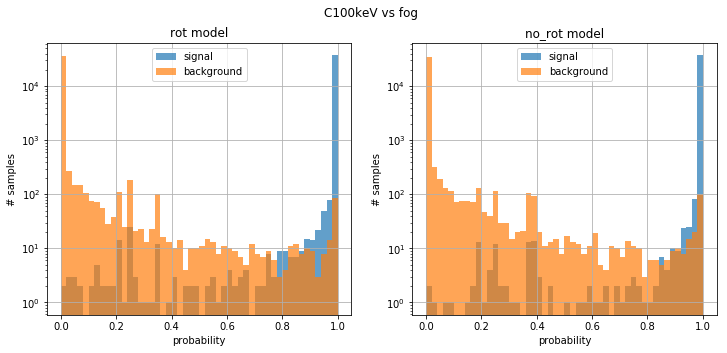

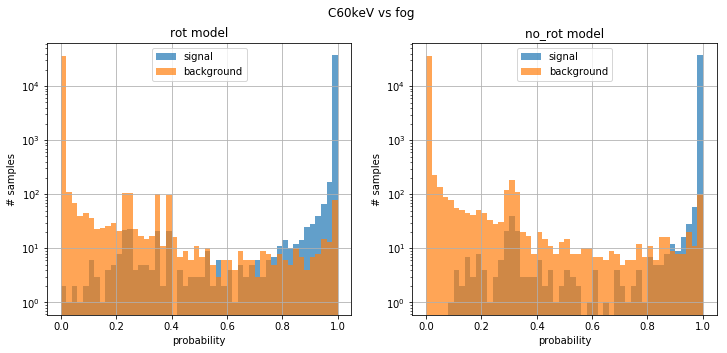

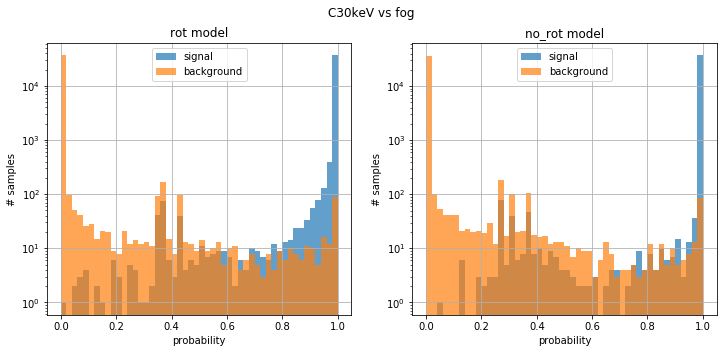

In [40]:
for k in class_names:
    pred_mean, pos, neg = {},{},{}
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i, tr in enumerate(train_types):
        n=k
        #if k!='C100keV': continue
        pos[k+'_'+n+'_'+tr], neg[k+'_'+n+'_'+tr] = np.zeros((0,2)), np.zeros((0,2))
        for s in [m for m in load_s if n in m]:
            pos[k+'_'+s+'_'+tr], neg[k+'_'+s+'_'+tr] = pos_neg(preds[k+'_'+s+'_'+tr][:,1], preds[k+'_'+s+'_'+tr][:,0])
            pos[k+'_'+n+'_'+tr] = np.vstack((pos[k+'_'+n+'_'+tr],pos[k+'_'+s+'_'+tr]))
            neg[k+'_'+n+'_'+tr] = np.vstack((neg[k+'_'+n+'_'+tr],neg[k+'_'+s+'_'+tr]))
        axes[i].hist(pos[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='signal', range=(0,1))
        axes[i].hist(neg[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='background', range=(0,1))
        axes[i].grid()
        axes[i].set_title(tr+' model')
        axes[i].set_yscale('log')
        axes[i].set_ylabel('# samples')
        axes[i].set_xlabel('probability')
        axes[i].legend(loc=9)
    plt.suptitle(k+' vs fog')
    plt.show()

In [ ]:
#preds[s+'_'+b+'_'+tr]

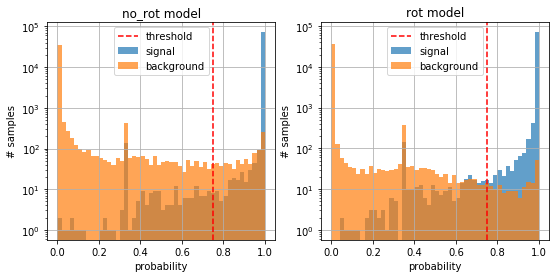

In [13]:
s = 'Carbon/100keV'
b = 'fog'
pred_mean, pos, neg = {},{},{}
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for i, tr in enumerate(train_types):
    pos[s+'_'+b+'_'+tr], neg[s+'_'+b+'_'+tr] = pos_neg(preds[s+'_'+b+'_'+tr][:,1], preds[s+'_'+b+'_'+tr][:,0])
    axes[i].hist(pos[s+'_'+b+'_'+tr][:,0], bins=50, alpha=0.7, label='signal', range=(0,1))
    axes[i].hist(neg[s+'_'+b+'_'+tr][:,0], bins=50, alpha=0.7, label='background', range=(0,1))
    axes[i].axvline(x=0.75, color='r', linestyle='--', label='threshold')
    axes[i].grid()
    axes[i].set_title(tr+' model')
    axes[i].set_yscale('log')
    axes[i].set_ylabel('# samples')
    axes[i].set_xlabel('probability')
    axes[i].legend(loc=9)
#plt.title(s+' vs fog')
plt.savefig('outputs/conv4_3d_res/v3/'+'_'.join(s.split('/'))+'_fog_pro'+'.pdf')
plt.show()

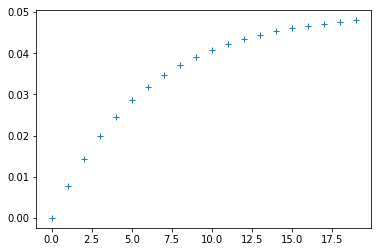

In [35]:
plt.plot((0.05-(np.logspace(0,2,num=20,base=5)**-1)*0.05),'+')

In [ ]:
(1-(np.logspace(0,3,num=20,base=5)**-1)*0.05)

In [ ]:
((np.logspace(0,3,num=20,base=5)**-1)*0.05)-0.0003

In [ ]:
sorted([0]+list(np.arange(0,0.1,0.01))+list(np.arange(0.1,0.9,0.1))+list(np.arange(0.9,1,0.01))+[1])

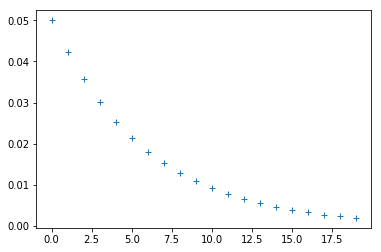

In [36]:
plt.plot(((np.logspace(0,2,num=20,base=5)**-1)*0.05),'+')

In [61]:
pos[s+'_'+b+'_'+tr]

array([[9.99613345e-01, 0.00000000e+00],
       [9.98880446e-01, 4.00000000e+00],
       [9.99972939e-01, 5.00000000e+00],
       ...,
       [9.99912143e-01, 1.10380000e+05],
       [9.99808967e-01, 1.10382000e+05],
       [9.99396324e-01, 1.10384000e+05]])

In [64]:
popos = pos[s+'_'+b+'_'+tr][:,0]
neneg = neg[s+'_'+b+'_'+tr][:,0]

In [66]:
tmp = popos[popos>0.2]
tmp = tmp[tmp<0.4]
tmp.sort()
np.median(tmp)

0.3486679494380951

In [69]:
tmp = neneg[neneg>0.2]
tmp = tmp[tmp<0.4]
tmp.sort()
np.median(tmp)

0.3486679494380951

Text(0.5, 0, 'probability')

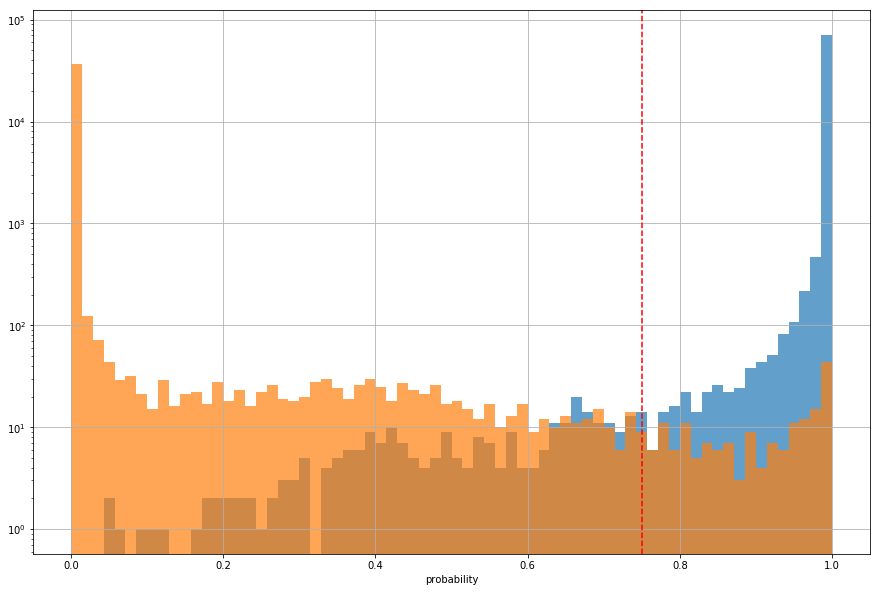

In [72]:
popos = pos[s+'_'+b+'_'+tr][:,0]
neneg = neg[s+'_'+b+'_'+tr][:,0]
plt.figure(figsize=(15,10))
bini = sorted([0]+list(np.arange(0,0.1,0.01))+list(np.arange(0.1,0.9,0.1))+list(np.arange(0.9,1,0.01))+[1])
plt.hist(popos[popos!=np.median(tmp)], bins=70, alpha=0.7, label='signal', range=(0,1))
plt.hist(neneg[neneg!=np.median(tmp)], bins=70, alpha=0.7, label='background', range=(0,1))
plt.axvline(x=0.75, color='r', linestyle='--', label='threshold')
plt.yscale('log')
plt.grid()
plt.xlabel('probability')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from keras.models import load_model
import keras.backend as K
def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)

model = load_model('/mnt/ML-drive/Artem/Python/NEWS/CNN/networks/res_v3/e50/rot/conv4_3d_res_Carbon-100keV_fog.h5', custom_objects={'swish':swish})

Using TensorFlow backend.


In [10]:
with h5py.File('/mnt/ML-drive/Artem/Python/NEWS/data/ready-to-float/Carbon-100keV_fog.h5','r') as cfile:
    X = cfile['train/images'][...]
    y = cfile['train/labels'][...]
    preds = model.predict(X[...,np.newaxis], batch_size=256, verbose=1)

165575/165575 [==============================] - 71s 431us/step


Text(0.5, 0, 'probability')

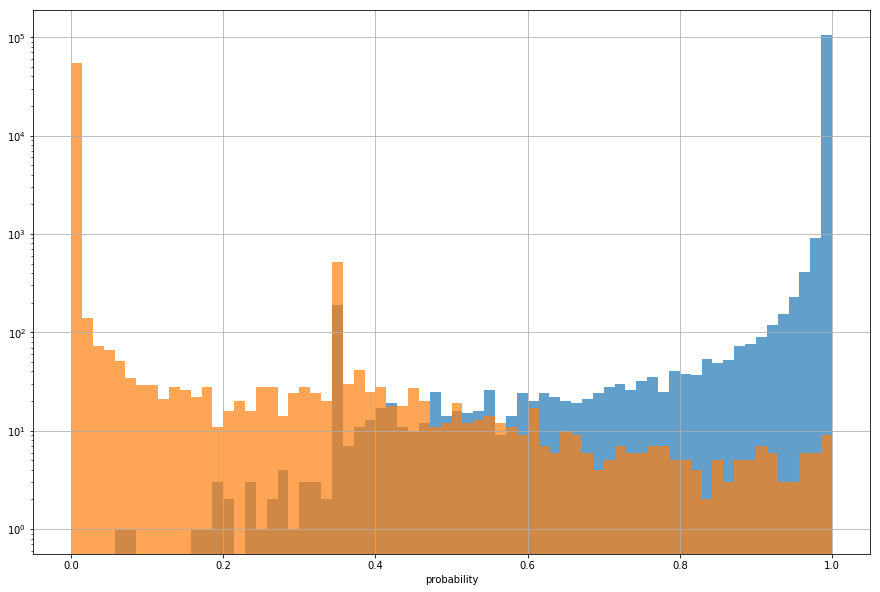

In [13]:
popos, neneg = pos_neg(y, preds)
plt.figure(figsize=(15,10))
plt.hist(popos[:,0], bins=70, alpha=0.7, label='signal', range=(0,1))
plt.hist(neneg[:,0], bins=70, alpha=0.7, label='background', range=(0,1))
plt.yscale('log')
plt.grid()
plt.xlabel('probability')

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 9, 1) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv3D)                (None, 32, 32, 9, 32 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv3D)                (None, 32, 32, 9, 32 27680       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling3D)            (None, 16, 16, 4, 32 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
res2a_bran

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
def block_Res( num, name, botton, top, s_filer=256, n_filer=64, offset="(0,0,0)", size=(32,32,3.5), opacity=0.5 ):
    lys = []
    layers = [ *[ '{}_{}'.format(name,i) for i in range(num-1) ], top]
    for name in layers:        
        ly = [ to_Conv( 
            name='{}'.format(name),       
            offset=offset, 
            to="({}-east)".format( botton ),   
            s_filer=str(s_filer), 
            n_filer=str(n_filer), 
            width=size[2],
            height=size[0],
            depth=size[1]
            ),
            to_connection( 
                "{}".format( botton  ), 
                "{}".format( name ) 
                )
            ]
        botton = name
        lys+=ly
    
    lys += [
        to_skip( of=layers[1], to=layers[-2], pos=1.25),
    ]
    return lys